In [18]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # nopep8
os.environ["TF_ENABLE_AUTO_MIXED_PRECISION"] = '1'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
FILE_PATH = os.getcwd()
import sys
sys.path.append('\\'.join(FILE_PATH.split('\\')[:3]))
import pandas as pd
from matplotlib import pyplot as plt
from trainvaltest import trainvaltest

In [2]:
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

MODEL_NAME = "the_first_war"
MODEL_PATH = f"{MODEL_NAME}"
BATCH_SIZE = 16
LABELS, INPUT_SHAPE, Train_Data, Val_Data, Test_Data = trainvaltest(BATCH_SIZE=BATCH_SIZE)
EPOCHS = 30
VERBOSE = 1


Train:
Found 205310 images belonging to 101 classes.
Validation:
Found 22758 images belonging to 101 classes.
Test:
Found 20267 images belonging to 101 classes.

Input shape -> (240, 240, 3) 



In [3]:
class Preprocess(layers.Layer):
    def __init__(self, factor=0.2, scale=1.0 / 255.0, flipmode='horizontal', seed=182):
        """Image preprocessing layer Block

        Args:
            factor (float, optional): factor to set for rotation, brightness, zoom and image shifting. Defaults to 0.2.
            scale (float, optional): float to multiple all features by and normalize tensorflow. Defaults to 1.0/255.0.
            seed (int, optional): set the seed value for all preprocessing layers. Defaults to 182
        """
        super(Preprocess, self).__init__()
        self.factor = factor
        self.scale = scale
        self.seed = seed
        self.flipmode = flipmode

        self.rescale = preprocessing.Rescaling(scale=self.scale)
        self.randomrotate = preprocessing.RandomRotation(factor=self.factor, seed=self.seed)
        self.randomzoom = preprocessing.RandomZoom(height_factor=self.factor, width_factor=self.factor, seed=self.seed)
        self.shift = preprocessing.RandomTranslation(height_factor=self.factor, width_factor=self.factor, seed=self.seed)
        self.flip = preprocessing.RandomFlip(mode=self.flipmode, seed=self.seed)

    @tf.function
    def call(self, image):
        """apply all preprocessing steps in

        Args:
            image (tensor): numerical data of image

        Returns:
            tensor: preprocessed data
        """
        image = self.rescale(image)
        image = self.randomrotate(image)
        image = self.randomzoom(image)
        image = self.shift(image)
        image = self.flip(image)
        return image

In [4]:
def conv_layer(filters, kernel_size, padding, strides):
    """Creates a convolution layer for CNNBlock

    Args:
        filters (int): number of filters in conv layer
        kernel_size (int): kernel size for conv layer
        padding (str): either 'same' padding or 'valid' padding
        strides (int): strides for conv layer

    Returns:
        conv layer: returns configured conv layer for CNNBlock
    """
    layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, padding=padding, strides=strides, activation=layers.ReLU())
    return layer

In [5]:
class CNNBlock(layers.Layer):
    def __init__(self, filters, triple=False, conv_kernel_size=(3, 3), conv_strides=(1, 1), pool_size=(2, 2), pool_strides=(2, 2), padding='same'):
        """block of either double (or triple) conv layers

        Args:
            filters (int): numbers of filters for the conv layers within this block
            triple (bool, optional): whether this conv block contains double (2) or triple (3) conv layers. Defaults to False.
            conv_strides (tuple, optional): tuple to set strides value for conv layers. Defaults to (1, 1).
            conv_kernel_size (tuple, optional): kernel size for the conv layers in this block. Defaults to (3, 3).
            pool_size (tuple, optional): pool size for pooling layer for this block. Defaults to (2, 2).
            pool_strides (tuple, optional): strides value for pooling for this block. Defaults to (2, 2).
            padding (str, optional): padding value of conv layers. Defaults to 'same'.
        """
        super(CNNBlock, self).__init__()
        self.triple = triple
        self.pool_size = pool_size
        self.pool_strides = pool_strides
        self.filters = filters
        self.conv_kernel_size = conv_kernel_size
        self.conv_strides = conv_strides
        self.padding = padding

        self.conv1 = conv_layer(filters=self.filters, kernel_size=self.conv_kernel_size, padding=self.padding, strides=self.conv_strides)
        self.conv2 = conv_layer(filters=self.filters, kernel_size=self.conv_kernel_size, padding=self.padding, strides=self.conv_strides)
        if self.triple == True:
            self.conv3 = conv_layer(filters=self.filters, kernel_size=self.conv_kernel_size, padding=self.padding, strides=self.conv_strides)
        self.bn = layers.BatchNormalization()
        self.maxpooling = layers.MaxPooling2D(pool_size=self.pool_size, strides=self.pool_strides)

    @tf.function
    def call(self, input_tensor, training=False):
        """forward propagation

        Args:
            input_tensor (input_tensor): input tensor for this data point
            training (bool): whether to set batch normalization to training or not

        Returns:
            tensor: output of the current CNN block
        """
        x = self.conv1(input_tensor)
        x = self.conv2(x)
        if self.triple == True:
            x = self.conv3(x)
        x = self.bn(x, training=training)
        x = self.maxpooling(x)
        return x

In [6]:
class Model(keras.Model):
    def __init__(self, n_labels):
        """model build via subclassing

        Args:
            n_labels (int): amount of labels for the model to predict
        """
        super(Model, self).__init__()
        self.n_labels = n_labels

        self.preprocess = Preprocess()
        self.cnnblock1 = CNNBlock(filters=64)
        self.cnnblock2 = CNNBlock(filters=128)
        self.cnnblock3 = CNNBlock(filters=256, triple=True)
        self.cnnblock4 = CNNBlock(filters=512, triple=True)
        self.cnnblock5 = CNNBlock(filters=512, triple=True)
        self.globalmaxpooling = layers.GlobalMaxPooling2D()
        self.flatten = layers.Flatten()
        self.fc = layers.Dense(4096, activation=layers.ReLU())
        self.dropout = layers.Dropout(0.25)
        self.outputs = layers.Dense(self.n_labels)

    @tf.function
    def call(self, input_tensor):
        """forward propagation for the entire model between each layer

        Args:
            input_tensor (tensor): output of the previous layer

        Returns:
            tensor: output of the previous tensor
        """
        x = self.preprocess(input_tensor)
        x = self.cnnblock1(x)
        x = self.cnnblock2(x)
        x = self.cnnblock3(x)
        x = self.cnnblock4(x)
        x = self.cnnblock5(x)
        x = self.globalmaxpooling(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = self.fc(x)
        x = self.outputs(x)
        return x

In [7]:
def create_model(inp_shape, n_labels, model_name, layer_names):
    """creates model (input and output), name layers and compile

    Args:
        inp_shape (tuple(int)): tuple of ints, input shape
        n_labels (int): number of labels for last layer
        model_name (str): name of model
        layer_names (list(str)): list of names for each layer in model

    Returns:
        model: named and configured model with input/output and named layers
    """
    model = Model(n_labels=n_labels)

    for i, layer in enumerate(model.layers):
        layer._name = layer_names[i]
    model._name = model_name
    model.build(input_shape=(None, *inp_shape))

    model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[keras.metrics.SparseCategoricalAccuracy(name='acc')])

    model.summary()
    return model

In [8]:
layer_names = tuple([
    "Preprocessing",
    "CNNBlock64_Double",
    "CNNBlock128_Double",
    "CNNBlock256_Triple",
    "CNNBlock512_Triple_1",
    "CNNBlock512_Triple_2",
    "GlobalMaxPooling",
    "Flatten",
    "FC",
    "Dropout",
    "Outputs"
])

model = create_model(inp_shape=INPUT_SHAPE, n_labels=LABELS, model_name=MODEL_NAME, layer_names=layer_names)
earlystopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=VERBOSE)
best_checkpoint = keras.callbacks.ModelCheckpoint(filepath=MODEL_PATH,
                                                  monitor='val_acc',
                                                  save_best_only=True,
                                                  save_freq='epoch',
                                                  verbose=VERBOSE)
callbacks = [earlystopping, best_checkpoint]

Model: "the_first_war"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Preprocessing (Preprocess)   multiple                  0         
_________________________________________________________________
CNNBlock64_Double (CNNBlock) multiple                  38976     
_________________________________________________________________
CNNBlock128_Double (CNNBlock multiple                  221952    
_________________________________________________________________
CNNBlock256_Triple (CNNBlock multiple                  1476352   
_________________________________________________________________
CNNBlock512_Triple_1 (CNNBlo multiple                  5901824   
_________________________________________________________________
CNNBlock512_Triple_2 (CNNBlo multiple                  7081472   
_________________________________________________________________
GlobalMaxPooling (GlobalMaxP multiple                

In [9]:
train = model.fit(Train_Data,
                  epochs=EPOCHS,
                  verbose=VERBOSE,
                  steps_per_epoch=len(Train_Data) // BATCH_SIZE,
                  callbacks=callbacks,
                  validation_data=Val_Data,
                  validation_steps=len(Val_Data) // BATCH_SIZE,
                  use_multiprocessing=True,
                  workers=-1)

Epoch 1/30
802/802 [==============================] - 1030s 1s/step - loss: 4.1971 - acc: 0.0901 - val_loss: 4.0370 - val_acc: 0.1009

Epoch 00001: val_acc improved from -inf to 0.10085, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 2/30
802/802 [==============================] - 991s 1s/step - loss: 3.5964 - acc: 0.1576 - val_loss: 3.7893 - val_acc: 0.1328

Epoch 00002: val_acc improved from 0.10085 to 0.13281, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 3/30
802/802 [==============================] - 973s 1s/step - loss: 3.2841 - acc: 0.2104 - val_loss: 3.7418 - val_acc: 0.1506

Epoch 00003: val_acc improved from 0.13281 to 0.15057, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 4/30
802/802 [==============================] - 886s 1s/step - loss: 3.0302 - acc: 0.2559 - val_loss: 3.6912 - val_acc: 0.1499

Epoch 00004: val_acc did not improve from 0.15057
Epoch 5/30
802/802 [==============================] - 943s 1s/step - loss: 2.8277 - acc: 0.2982 - val_loss: 3.5318 - val_acc: 0.1982

Epoch 00005: val_acc improved from 0.15057 to 0.19815, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 6/30
802/802 [==============================] - 867s 1s/step - loss: 2.5869 - acc: 0.3466 - val_loss: 3.4116 - val_acc: 0.2017

Epoch 00006: val_acc improved from 0.19815 to 0.20170, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 7/30
802/802 [==============================] - 848s 1s/step - loss: 2.3810 - acc: 0.3998 - val_loss: 3.4860 - val_acc: 0.2031

Epoch 00007: val_acc improved from 0.20170 to 0.20312, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 8/30
802/802 [==============================] - 818s 1s/step - loss: 2.2039 - acc: 0.4338 - val_loss: 3.3685 - val_acc: 0.2287

Epoch 00008: val_acc improved from 0.20312 to 0.22869, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 9/30
802/802 [==============================] - 801s 999ms/step - loss: 2.0033 - acc: 0.4836 - val_loss: 3.2972 - val_acc: 0.2507

Epoch 00009: val_acc improved from 0.22869 to 0.25071, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 10/30
802/802 [==============================] - 784s 977ms/step - loss: 1.8206 - acc: 0.5202 - val_loss: 3.1629 - val_acc: 0.2884

Epoch 00010: val_acc improved from 0.25071 to 0.28835, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 11/30
802/802 [==============================] - 791s 986ms/step - loss: 1.6516 - acc: 0.5639 - val_loss: 3.1422 - val_acc: 0.3047

Epoch 00011: val_acc improved from 0.28835 to 0.30469, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 12/30
802/802 [==============================] - 801s 999ms/step - loss: 1.4959 - acc: 0.6013 - val_loss: 3.1661 - val_acc: 0.3125

Epoch 00012: val_acc improved from 0.30469 to 0.31250, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 13/30
802/802 [==============================] - 786s 980ms/step - loss: 1.3463 - acc: 0.6407 - val_loss: 3.0755 - val_acc: 0.3445

Epoch 00013: val_acc improved from 0.31250 to 0.34446, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 14/30
802/802 [==============================] - 772s 963ms/step - loss: 1.2277 - acc: 0.6644 - val_loss: 3.2269 - val_acc: 0.3551

Epoch 00014: val_acc improved from 0.34446 to 0.35511, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 15/30
802/802 [==============================] - 785s 979ms/step - loss: 1.1166 - acc: 0.6972 - val_loss: 3.1025 - val_acc: 0.3523

Epoch 00015: val_acc did not improve from 0.35511
Epoch 16/30
802/802 [==============================] - 759s 946ms/step - loss: 1.0346 - acc: 0.7181 - val_loss: 2.9536 - val_acc: 0.3892

Epoch 00016: val_acc improved from 0.35511 to 0.38920, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 17/30
802/802 [==============================] - 762s 951ms/step - loss: 0.9545 - acc: 0.7385 - val_loss: 2.9984 - val_acc: 0.4006

Epoch 00017: val_acc improved from 0.38920 to 0.40057, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 18/30
802/802 [==============================] - 745s 929ms/step - loss: 0.8703 - acc: 0.7573 - val_loss: 3.1520 - val_acc: 0.3899

Epoch 00018: val_acc did not improve from 0.40057
Epoch 19/30
802/802 [==============================] - 727s 907ms/step - loss: 0.8018 - acc: 0.7766 - val_loss: 3.1308 - val_acc: 0.4055

Epoch 00019: val_acc improved from 0.40057 to 0.40554, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 20/30
802/802 [==============================] - 772s 963ms/step - loss: 0.7368 - acc: 0.7908 - val_loss: 2.9862 - val_acc: 0.4119

Epoch 00020: val_acc improved from 0.40554 to 0.41193, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 21/30
802/802 [==============================] - 746s 931ms/step - loss: 0.7184 - acc: 0.8030 - val_loss: 2.9634 - val_acc: 0.4460

Epoch 00021: val_acc improved from 0.41193 to 0.44602, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 22/30
802/802 [==============================] - 760s 948ms/step - loss: 0.6720 - acc: 0.8094 - val_loss: 3.0550 - val_acc: 0.4205

Epoch 00022: val_acc did not improve from 0.44602
Epoch 23/30
802/802 [==============================] - 716s 893ms/step - loss: 0.6151 - acc: 0.8268 - val_loss: 2.7699 - val_acc: 0.4531

Epoch 00023: val_acc improved from 0.44602 to 0.45312, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 24/30
802/802 [==============================] - 718s 896ms/step - loss: 0.5875 - acc: 0.8333 - val_loss: 2.9252 - val_acc: 0.4538

Epoch 00024: val_acc improved from 0.45312 to 0.45384, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 25/30
802/802 [==============================] - 722s 901ms/step - loss: 0.5532 - acc: 0.8491 - val_loss: 2.8613 - val_acc: 0.4751

Epoch 00025: val_acc improved from 0.45384 to 0.47514, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 26/30
802/802 [==============================] - 729s 909ms/step - loss: 0.5341 - acc: 0.8459 - val_loss: 2.8844 - val_acc: 0.4801

Epoch 00026: val_acc improved from 0.47514 to 0.48011, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 27/30
802/802 [==============================] - 725s 904ms/step - loss: 0.4955 - acc: 0.8580 - val_loss: 2.9003 - val_acc: 0.4680

Epoch 00027: val_acc did not improve from 0.48011
Epoch 28/30
802/802 [==============================] - 699s 871ms/step - loss: 0.4960 - acc: 0.8596 - val_loss: 2.8761 - val_acc: 0.4893

Epoch 00028: val_acc improved from 0.48011 to 0.48935, saving model to the_first_war


INFO:tensorflow:Assets written to: the_first_war\assets


INFO:tensorflow:Assets written to: the_first_war\assets


Epoch 29/30
802/802 [==============================] - 712s 888ms/step - loss: 0.4604 - acc: 0.8691 - val_loss: 2.9551 - val_acc: 0.4723

Epoch 00029: val_acc did not improve from 0.48935
Epoch 30/30
802/802 [==============================] - 685s 854ms/step - loss: 0.4389 - acc: 0.8746 - val_loss: 2.9222 - val_acc: 0.4879

Epoch 00030: val_acc did not improve from 0.48935


In [10]:
test = model.evaluate(Test_Data, steps=len(Test_Data) // BATCH_SIZE, workers=-1, use_multiprocessing=True, verbose=VERBOSE)

79/79 [==============================] - 77s 979ms/step - loss: 4.5920 - acc: 0.2729


In [32]:
train_history = pd.DataFrame(train.history)
train_history.head()

,loss,acc,val_loss,val_acc
0,4.197140,0.090087,4.036989,0.100852
1,3.596387,0.157575,3.789301,0.132812
2,3.284070,0.210411,3.741821,0.150568
3,3.030231,0.255923,3.691170,0.149858
4,2.827677,0.298161,3.531843,0.198153


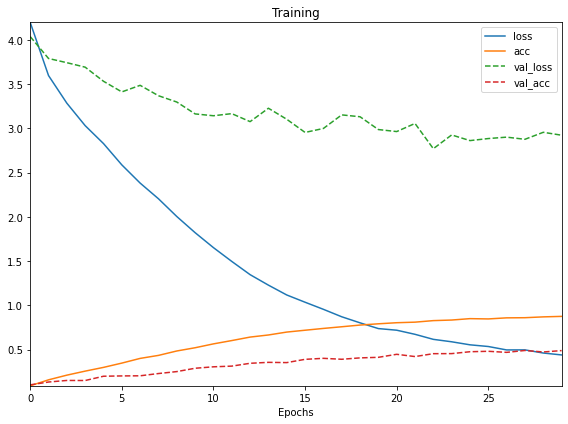

In [48]:
plt.figure(figsize=(8, 6))
plt.title("Training")
def plotline(label):
    return plt.plot(train_history[label], label=label, linestyle='--' if label[:3]=='val' else '-')

for label in train_history.keys():
    plotline(label=label)
plt.xlabel('Epochs')
plt.legend()
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()